KCI_jpg변환

In [ ]:
import os
from glob import glob
from PIL import Image

# 입력/출력 경로
input_root  = "/content/drive/MyDrive/ky_test"   # 원본 PNG 데이터셋
output_root = "/content/drive/MyDrive/ky_test_jpg"  # 새 JPG 데이터셋

# 출력 폴더 생성
os.makedirs(output_root, exist_ok=True)

# 하위 폴더(real, fake) 단위로 반복
for cls in ["real", "fake"]:
    in_dir  = os.path.join(input_root, cls)
    out_dir = os.path.join(output_root, cls)
    os.makedirs(out_dir, exist_ok=True)

    for img_path in glob(os.path.join(in_dir, "*")):
        try:
            img = Image.open(img_path).convert("RGB")   # PNG → RGB
            base = os.path.splitext(os.path.basename(img_path))[0]
            out_path = os.path.join(out_dir, base + ".jpg")
            img.save(out_path, "JPEG", quality=90)      # JPEG 저장
        except Exception as e:
            print("변환 실패:", img_path, e)

print("완료: JPG 데이터셋 생성됨 →", output_root)

#기본 전처리


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import pytesseract
from pytesseract import Output

# 경로 설정
input_root = "/content/drive/MyDrive/polypgen_datasetNinja_img"
output_root = "/content/drive/MyDrive/PREpolypgen_datasetNinja_img"
os.makedirs(output_root, exist_ok=True)

# 좌측 UI 박스 감지 함수
def has_ui_corner_block(img, min_area=800, epsilon_ratio=0.02):
    h, w = img.shape[:2]
    roi = img[int(h * 2/3):, :int(w / 3)]
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([20, 20, 20])
    black_mask = cv2.inRange(roi, lower_black, upper_black)
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)

    def detect(mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > min_area:
                epsilon = epsilon_ratio * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                if len(approx) == 4:
                    return True
        return False

    return detect(black_mask) or detect(green_mask)

# 모든 하위 폴더의 이미지 경로 수집
image_paths = sorted(glob(os.path.join(input_root, "**", "*.jpg"), recursive=True))
total_images = len(image_paths)
processed_images_count = 0

print(f"✅ 총 시작 이미지 수: {total_images}장")

# 메인 루프
for img_path in tqdm(image_paths):
    img = cv2.imread(img_path)
    if img is None:
        continue

    # ✅ 512x512로 resize
    img = cv2.resize(img, (512, 512))

    # ✅ UI 박스 있으면 제외
    if has_ui_corner_block(img):
        continue

    # UI가 없는 이미지만 카운트
    processed_images_count += 1

    # ✅ CLAHE 적용
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    img_final = cv2.cvtColor(cv2.merge((l_eq, a, b)), cv2.COLOR_LAB2BGR)

    # ✅ ROI 설정: 좌측 1/4, 세로 10%~80%
    h, w = img_final.shape[:2]
    x_start, x_end = 0, w // 4
    y_start, y_end = int(h * 0.1), int(h * 0.8)
    roi = img_final[y_start:y_end, x_start:x_end]
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # ✅ OCR 수행
    _, thresh = cv2.threshold(gray_roi, 150, 255, cv2.THRESH_BINARY_INV)
    custom_config = r'--oem 3 --psm 11'
    data = pytesseract.image_to_data(thresh, config=custom_config, output_type=Output.DICT)

    # ✅ 마스크 초기화
    gray_img = cv2.cvtColor(img_final, cv2.COLOR_BGR2GRAY)
    mask_ocr = np.zeros_like(gray_img, dtype=np.uint8)

    # ✅ OCR 박스 기반 마스킹
    for i in range(len(data['text'])):
        text = data['text'][i]
        try:
            conf = int(data['conf'][i])
        except:
            conf = 0
        if conf >= 50 and text.strip() != "":
            x, y, w_box, h_box = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            abs_x, abs_y = x_start + x, y_start + y
            patch = img_final[abs_y:abs_y+h_box, abs_x:abs_x+w_box]
            patch_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
            _, text_mask = cv2.threshold(patch_gray, 160, 255, cv2.THRESH_BINARY)

            # ✅ dilate 강도 조절
            kernel = np.ones((5, 5), np.uint8)
            text_mask = cv2.dilate(text_mask, kernel, iterations=2) # 팽창 횟수 감소

            mask_ocr[abs_y:abs_y+h_box, abs_x:abs_x+w_box] = cv2.bitwise_or(
                mask_ocr[abs_y:abs_y+h_box, abs_x:abs_x+w_box], text_mask
            )

    # ✅ 밝은 픽셀 직접 마스킹 (OCR 누락 대비)
    _, bright_mask = cv2.threshold(gray_roi, 210, 255, cv2.THRESH_BINARY)
    bright_mask = cv2.dilate(bright_mask, np.ones((3,3), np.uint8), iterations=1) # 커널, 횟수 감소
    mask_ocr[y_start:y_end, x_start:x_end] = cv2.bitwise_or(mask_ocr[y_start:y_end, x_start:x_end], bright_mask)

    # ✅ 인페인트 + 블러 (강도 조절)
    img_removed = cv2.inpaint(img_final, mask_ocr, 10, cv2.INPAINT_TELEA) # 인페인트 반지름 20 -> 10
    blurred = img_removed.copy()
    blurred[mask_ocr == 255] = cv2.GaussianBlur(img_removed, (11, 11), 0)[mask_ocr == 255] # 블러 커널 (17,17) -> (13,13)

    # ✅ 선택: 마스크 전체 한번 더 부드럽게 (블러 커널 크기 감소)
    blurred = cv2.GaussianBlur(blurred, (3, 3), 0) # 블러 커널 (5,5) -> (3,3)

    # ✅ 덮어쓰기 저장 전에 먼저 임시로 저장
    filename_without_ext, _ = os.path.splitext(os.path.basename(img_path))
    temp_save_path = os.path.join(output_root, f"{filename_without_ext}.png")
    cv2.imwrite(temp_save_path, blurred)

    # ✅ 2차 처리: 자동 자르기
    img_crop = cv2.imread(temp_save_path)
    if img_crop is None:
        continue

    # ✅ Grayscale + 마스킹
    gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # ✅ 모폴로지 열림 연산으로 잡음 제거
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    coords = cv2.findNonZero(mask)
    if coords is None:
        continue # 검정 아닌 영역 없으면 스킵

    x, y, w, h = cv2.boundingRect(coords)

    # ✅ 여유를 조금 빼서 확실히 테두리 없애기
    margin = 5
    x, y = max(0, x + margin), max(0, y + margin)
    w, h = max(1, w - 2 * margin), max(1, h - 2 * margin)

    cropped = img_crop[y:y+h, x:x+w]

    # ✅ 다시 512x512로 resize
    resized = cv2.resize(cropped, (512, 512), interpolation=cv2.INTER_AREA)

    # ✅ 최종 저장
    cv2.imwrite(temp_save_path, resized)

    # ✅ 하단 1/30 절단 및 모서리 검정색 덮기 (추가된 코드)

    img_to_process = cv2.imread(temp_save_path)
    if img_to_process is None:
        continue

    h, w = img_to_process.shape[:2]

    # ✅ 하단 1/30 절단
    cut_height = h // 30
    img_cropped_final = img_to_process[0:h-cut_height, :]

    # ✅ 512x512 리사이즈
    img_final_resize = cv2.resize(img_cropped_final, (512, 512), interpolation=cv2.INTER_AREA)

    # ✅ 모서리 삼각형 검정색 덮기
    h, w = img_final_resize.shape[:2]
    triangle_size = 100
    mask = np.zeros((h, w), dtype=np.uint8)

    # 좌상단 삼각형
    pts1 = np.array([[0, 0], [triangle_size, 0], [0, triangle_size]], np.int32)
    cv2.fillPoly(mask, [pts1], 255)

    # 우상단 삼각형
    pts2 = np.array([[w, 0], [w-triangle_size, 0], [w, triangle_size]], np.int32)
    cv2.fillPoly(mask, [pts2], 255)

    # 좌하단 삼각형
    pts3 = np.array([[0, h], [0, h-triangle_size], [triangle_size, h]], np.int32)
    cv2.fillPoly(mask, [pts3], 255)

    # 우하단 삼각형
    pts4 = np.array([[w, h], [w-triangle_size, h], [w, h-triangle_size]], np.int32)
    cv2.fillPoly(mask, [pts4], 255)

    # 검정색으로 덮기
    img_final_resize[mask == 255] = (0, 0, 0)

    # ✅ 최종 결과 저장 (덮어쓰기)
    cv2.imwrite(temp_save_path, img_final_resize)

print(f"\n✅ UI 감지 함수를 통과한 최종 이미지 수: {processed_images_count}장")

✅ 총 시작 이미지 수: 8037장


100%|██████████| 8037/8037 [52:02<00:00,  2.57it/s]


✅ UI 감지 함수를 통과한 최종 이미지 수: 6458장


In [ ]:
import os

# 폴더 경로 설정
folder_path = '/content/drive/MyDrive/dataset/mri_gan_train'

# 파일 개수 세기
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"'{folder_path}' 폴더에 있는 이미지 파일의 개수: {file_count}장")

'/content/drive/MyDrive/dataset/mri_gan_train' 폴더에 있는 이미지 파일의 개수: 430장


In [ ]:
import os

folder_path = '/content/drive/MyDrive/PREpolypgen_datasetNinja_img'

# 해당 폴더가 존재하는지 확인
if not os.path.exists(folder_path):
    print(f"Error: The folder '{folder_path}' does not exist.")
else:
    # 폴더 내의 모든 파일 목록 가져오기
    files_to_delete = [
        f for f in os.listdir(folder_path)
        if f.startswith('seq')
    ]

    if not files_to_delete:
        print("There are no files starting with 'seq' in the folder.")
    else:
        # 'seq'로 시작하는 파일들 삭제
        for filename in files_to_delete:
            file_path = os.path.join(folder_path, filename)
            try:
                os.remove(file_path)
                print(f"Deleted: {filename}")
            except OSError as e:
                print(f"Error deleting file {filename}: {e}")

        print(f"\n✅ All files starting with 'seq' have been successfully deleted from {folder_path}.")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Deleted: seq12_EndoCV2021_seq12_936.png
Deleted: seq4_EndoCV2021_seq4_neg_Image_20743.png
Deleted: seq15_EndoCV2021_seq15_108.png
Deleted: seq2_EndoCV2021_seq2_neg_48_endocv2021_negative_542.png
Deleted: seq13_EndoCV2021_seq13_368.png
Deleted: seq8_EndoCV2021_seq8_neg_45_endocv2021_negative_763.png
Deleted: seq22_seq22_neg_00182.png
Deleted: seq2_0_endocv2021_positive_932.png
Deleted: seq22_seq22_neg_00171.png
Deleted: seq20_seq20_neg_0035.png
Deleted: seq13_EndoCV2021_C5_seq3_3.png
Deleted: seq11_EndoCV2021_seq11_Image_2194481.png
Deleted: seq5_EndoCV2021_seq5_228.png
Deleted: seq13_EndoCV2021_seq13_240.png
Deleted: seq5_EndoCV2021_seq5_324.png
Deleted: seq22_seq7_C6_420.png
Deleted: seq13_EndoCV2021_C5_seq3_268.png
Deleted: seq16_seq1_C6_10.png
Deleted: seq2_EndoCV2021_seq2_neg_48_endocv2021_negative_245.png
Deleted: seq19_seq4_C6_516.png
Deleted: seq14_seq14_neg_0092.png
Deleted: seq2_0_endocv2021_positive_1181.png
Deleted: seq23_seq23_neg_006.png

#=================================================================
#fid계산
#=================================================================

##Real VS Fake fid

In [ ]:
import os, numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from scipy import linalg
from tqdm import tqdm
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# ----------------------------
# Dataset
# ----------------------------
class ImageFolderDataset(Dataset):
    def __init__(self, folder, transform):
        exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]
        self.transform = transform
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.transform(img)

# ----------------------------
# InceptionV3 feature extractor (pool3=avgpool → 2048)
# ----------------------------
def build_extractor(device):
    weights = Inception_V3_Weights.DEFAULT
    base = inception_v3(weights=weights).to(device).eval()  # aux_logits 인자 제거
    extractor = create_feature_extractor(base, return_nodes={'avgpool': 'feat'})
    transform = weights.transforms()
    return extractor, transform

@torch.no_grad()
def get_activations(folder, device='cpu', batch_size=4, num_workers=2):
    extractor, transform = build_extractor(device)
    ds = ImageFolderDataset(folder, transform)
    if len(ds) == 0:
        raise ValueError(f"No images found in: {folder}")
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=(device=='cuda'))
    feats = []
    for x in tqdm(dl, desc=os.path.basename(folder) or folder):
        x = x.to(device, non_blocking=True)
        out = extractor(x)['feat']          # [N, 2048, 1, 1]
        out = out.flatten(1).cpu().numpy()  # [N, 2048]
        feats.append(out)
    feats = np.concatenate(feats, axis=0)
    return feats

def frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean): covmean = covmean.real
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_fid(folder1, folder2, device=None, batch_size=4, num_workers=2):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    act1 = get_activations(folder1, device, batch_size, num_workers)
    act2 = get_activations(folder2, device, batch_size, num_workers)
    mu1, sigma1 = act1.mean(0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(0), np.cov(act2, rowvar=False)
    return float(frechet_distance(mu1, sigma1, mu2, sigma2))

# ----------------------------
# 실행 예시
# ----------------------------
if __name__ == "__main__":
    real_path = r"/content/drive/MyDrive/Normal_Fake_Test_374"
    fake_path = r"/content/drive/MyDrive/KCI_normal_test/fake"
    fid = compute_fid(real_path, fake_path, batch_size=2, num_workers=2)
    print(f"FID: {fid:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)
Normal_Fake_Test_374: 100%|██████████| 187/187 [00:09<00:00, 20.57it/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)
fake: 100%|██████████| 250/250 [00:11<00:00, 22.22it/s]
/tmp/ipython-input-1965607484.py:54: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = l

FID: 76.8378


##Self-fid

In [ ]:
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
from scipy import linalg

rng = np.random.default_rng(0)
torch.manual_seed(0)

# ----------------------------
# Feature extractor
# ----------------------------
def build_extractor(device):
    w = Inception_V3_Weights.DEFAULT
    base = inception_v3(weights=w).to(device).eval()
    extractor = create_feature_extractor(base, return_nodes={'avgpool':'feat'})
    transform = w.transforms()
    return extractor, transform

class PathsDS(Dataset):
    def __init__(self, files, transform):
        self.files, self.t = files, transform
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        return self.t(img)

def list_images(folder):
    exts = (".jpg",".jpeg",".png",".bmp",".webp")
    fs = [os.path.join(folder,f) for f in os.listdir(folder) if f.lower().endswith(exts)]
    good = []
    for p in fs:
        try:
            with Image.open(p) as im: im.verify()
            good.append(p)
        except Exception:
            pass
    return good

@torch.no_grad()
def activations(files, device='cuda', bs=8, nw=2):
    extractor, t = build_extractor(device)
    dl = DataLoader(PathsDS(files, t), batch_size=bs, shuffle=False,
                    num_workers=nw, pin_memory=(device=='cuda'))
    out = []
    for x in tqdm(dl, desc=f"acts {len(files)}"):
        x = x.to(device, non_blocking=True)
        f = extractor(x)['feat'].flatten(1).cpu().numpy()
        out.append(f)
    return np.concatenate(out, axis=0).astype(np.float64)

def fid_from_acts(a, b):
    mu1, s1 = a.mean(0), np.cov(a, rowvar=False)
    mu2, s2 = b.mean(0), np.cov(b, rowvar=False)
    covmean, _ = linalg.sqrtm(s1 @ s2, disp=False)
    if np.iscomplexobj(covmean): covmean = covmean.real
    diff = mu1 - mu2
    return float(diff @ diff + np.trace(s1 + s2 - 2*covmean))

# ----------------------------
# Self-FID
# ----------------------------
def self_fid(folder, runs=5, frac=0.5, device=None, bs=8, nw=2):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    files = list_images(folder)
    n = len(files)
    if n < 20:
        raise ValueError("이미지가 너무 적음 (≥20 권장)")
    m = int(n * frac)

    acts = activations(files, device, bs, nw)
    fids = []
    for _ in range(runs):
        idx = rng.permutation(n)
        a = acts[idx[:m]]; b = acts[idx[m:2*m]]
        fids.append(fid_from_acts(a, b))

    return float(np.mean(fids)), float(np.std(fids)), fids

# ----------------------------
# 사용 예시
# ----------------------------
path = "/content/drive/MyDrive/Normal_Fake_Test_374"
mean_fid, std_fid, all_fids = self_fid(path, runs=5, frac=0.5, bs=4, nw=2)
print("각 run self-FID:", [round(x,2) for x in all_fids])
print(f"평균 self-FID = {mean_fid:.2f} ± {std_fid:.2f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)
acts 374: 100%|██████████| 94/94 [00:06<00:00, 13.51it/s]
/tmp/ipython-input-931050219.py:57: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(s1 @ s2, disp=False)


각 run self-FID: [68.24, 65.11, 68.33, 62.46, 69.53]
평균 self-FID = 66.74 ± 2.59


##Precision/Recall

In [ ]:
# pip install prdc torchvision
import os, torch, numpy as np
from PIL import Image
from torchvision import models, transforms
from prdc import compute_prdc as prdc

real_path = "/content/drive/MyDrive/Normal_Fake_Test_374"
fake_path = "/content/drive/MyDrive/KCI_normal_test/fake"

tf = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def load_feats(path, bs=64, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # InceptionV3에서 fc 제거 → 특징 추출
    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Identity()
    model.eval().to(device)

    files = [f for f in os.listdir(path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    feats = []
    with torch.no_grad():
        for i in range(0, len(files), bs):
            batch = []
            for f in files[i:i+bs]:
                img = tf(Image.open(os.path.join(path,f)).convert('RGB'))
                batch.append(img)
            x = torch.stack(batch).to(device)
            feats.append(model(x).cpu().numpy())
    return np.concatenate(feats, axis=0)

real_f = load_feats(real_path)
fake_f = load_feats(fake_path)

res = prdc(real_features=real_f, fake_features=fake_f, nearest_k=5)
print(res)  # {'precision': ..., 'recall': ..., 'density': ..., 'coverage': ...}


Num real: 374 Num fake: 500
{'precision': np.float64(0.816), 'recall': np.float64(0.31283422459893045), 'density': np.float64(1.022), 'coverage': np.float64(0.8877005347593583)}


#===============================================================
#MRI 전처리
#===============================================================

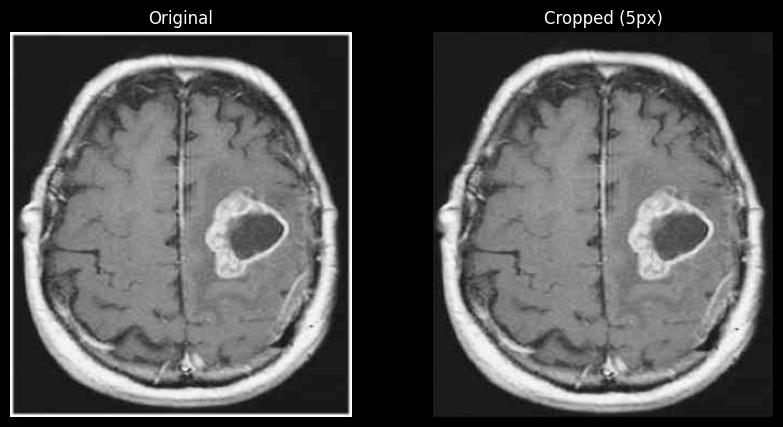

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 테스트용 이미지 경로 하나 지정
test_img_path = "/content/drive/MyDrive/dataset/Brain Tumor Data Set/뇌종양/Cancer(905).jpg"

# 자를 픽셀 수
crop_size = 5

# 이미지 불러오기 (BGR → RGB 변환)
img = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w = img.shape[:2]
cropped = img[crop_size:h-crop_size, crop_size:w-crop_size]
cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)

# 시각화 (배경 검정색)
fig = plt.figure(figsize=(10,5), facecolor="black")

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_rgb)
ax1.set_title("Original", color="white")
ax1.axis("off")
ax1.set_facecolor("black")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cropped_rgb)
ax2.set_title(f"Cropped ({crop_size}px)", color="white")
ax2.axis("off")
ax2.set_facecolor("black")

plt.show()


In [ ]:
import cv2, os, numpy as np
from glob import glob
from tqdm import tqdm

input_folder = "/content/drive/MyDrive/dataset/Brain Tumor Data Set/뇌종양"
crop_size   = 5
target_size = 512
#exts = ["*.jpg", "*.png", "*.jpeg", "*.tif", "*.tiff"]
exts = ["*.JPG"]
paths = []
for ext in exts:
    paths += glob(os.path.join(input_folder, "**", ext), recursive=True)

for p in tqdm(paths):
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None:
        print("로드 실패:", p); continue

    # 16비트 → 8비트(선형 스케일)
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 채널 정규화: 1ch→BGR, 4ch→BGR, 3ch 유지
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    h, w = img.shape[:2]
    if h <= 2*crop_size or w <= 2*crop_size:
        print("크롭 후 유효 영역 없음:", p); continue
    img = img[crop_size:h-crop_size, crop_size:w-crop_size]

    # 비율 유지 리사이즈
    h, w = img.shape[:2]
    scale = min(target_size / w, target_size / h)
    new_w, new_h = max(1, int(w * scale)), max(1, int(h * scale))
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 512×512 검정 배경에 중앙 배치
    canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    x = (target_size - new_w) // 2
    y = (target_size - new_h) // 2
    canvas[y:y+new_h, x:x+new_w] = resized

    # .jpg로 저장하고 원본 삭제
    base, _ = os.path.splitext(p)
    out_path = base + ".jpg"
    cv2.imwrite(out_path, canvas, [cv2.IMWRITE_JPEG_QUALITY, 95])
    if out_path != p:
        try: os.remove(p)
        except Exception as e: print("원본 삭제 실패:", p, e)


100%|██████████| 61/61 [00:24<00:00,  2.46it/s]


In [ ]:
import os
import shutil
import random
from glob import glob

# 입력 폴더
input_folder = "/content/drive/MyDrive/dataset/Brain Tumor Data Set/뇌종양"
# 출력 폴더들
output_folders = [
    "/content/drive/MyDrive/dataset/mri_dis_train",
    "/content/drive/MyDrive/dataset/mri_dis_test",
    "/content/drive/MyDrive/dataset/mri_gan_train",
    "/content/drive/MyDrive/dataset/mri_gan_test",
]

# 출력 폴더 생성
for f in output_folders:
    os.makedirs(f, exist_ok=True)

# 이미지 경로 수집 (jpg/png 모두 포함 가능)
exts = ["*.jpg", "*.jpeg", "*.png"]
image_paths = []
for ext in exts:
    image_paths.extend(glob(os.path.join(input_folder, ext)))

print("총 이미지 개수:", len(image_paths))  # 1722 예상

# 랜덤 셔플
random.seed(42)
random.shuffle(image_paths)

# 430장씩 4개 그룹으로 나누기
n = 430
splits = [image_paths[i:i+n] for i in range(0, n*4, n)]

# 각 그룹을 지정 폴더에 저장
for folder, imgs in zip(output_folders, splits):
    for img in imgs:
        shutil.copy(img, folder)

print("완료. 각 폴더에 430장씩 저장됨.")

총 이미지 개수: 1722
완료. 각 폴더에 430장씩 저장됨.


In [ ]:
import os
from glob import glob
from PIL import Image

# 변환할 폴더들
folders = [
    "/content/drive/MyDrive/dataset/mri_dis_train",
    "/content/drive/MyDrive/dataset/mri_dis_test",
    "/content/drive/MyDrive/dataset/mri_gan_train",
    "/content/drive/MyDrive/dataset/mri_gan_test",
]

for folder in folders:
    paths = glob(os.path.join(folder, "*"))
    for path in paths:
        try:
            img = Image.open(path).convert("RGB")  # RGB로 변환 후 저장
            new_path = os.path.splitext(path)[0] + ".png"
            img.save(new_path, "PNG")

            # 원본 파일 삭제 (원하면 주석 해제)
            os.remove(path)
        except Exception as e:
            print("변환 실패:", path, e)

print("변환 완료")

변환 완료


#============================================================
#Polyp_후처리 및 선별
#============================================================

In [ ]:
import os, random, shutil
from glob import glob

# ===== 설정 =====
SRC_DIR   = "/content/drive/MyDrive/dataset/normal_fake_test"  # 원본 폴더
DST_DIR   = "/content/drive/MyDrive/normal_test_374_generated_images_selected500"    # 복사 대상 폴더
NUM       = 500                                            # 뽑을 장수
SEED      = 42                                             # 재현 가능성 위해 고정(원치 않으면 None)
EXTS      = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.tif","*.tiff","*.bmp","*.webp"]
RECURSIVE = True                                           # 하위폴더 포함 여부
# =================

# 파일 수집
paths = []
for ext in EXTS:
    pattern = os.path.join(SRC_DIR, "**", ext) if RECURSIVE else os.path.join(SRC_DIR, ext)
    paths += glob(pattern, recursive=RECURSIVE)

# 중복 제거 및 섞기
paths = sorted(set(paths))
if SEED is not None:
    random.seed(SEED)
random.shuffle(paths)

# 수량 확인
if len(paths) < NUM:
    raise ValueError(f"이미지 부족: {len(paths)}개 발견. 최소 {NUM}개 필요. SRC_DIR를 확인하세요.")

# 샘플 선정
sampled = paths[:NUM]

# 복사
os.makedirs(DST_DIR, exist_ok=True)
for i, src in enumerate(sampled, 1):
    base = os.path.basename(src)
    # 이름 충돌 방지: 앞에 인덱스 접두어
    dst = os.path.join(DST_DIR, f"{i:04d}_{base}")
    shutil.copy2(src, dst)

print(f"완료: {NUM}장 → {DST_DIR}")


완료: 500장 → /content/drive/MyDrive/normal_test_374_generated_images_selected500


#모서리 삼각형 적용

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm

# ===== 설정 =====
input_folder  = "/content/drive/MyDrive/dataset/input_images"   # 원본 폴더
output_folder = "/content/drive/MyDrive/dataset/output_images"  # 결과 저장 폴더
triangle_size = 100                                             # 삼각형 크기 (px)
exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]      # 처리할 확장자
# =================

os.makedirs(output_folder, exist_ok=True)

# 이미지 경로 수집
paths = []
for ext in exts:
    paths += glob(os.path.join(input_folder, ext))

for img_path in tqdm(paths):
    img = cv2.imread(img_path)
    if img is None:
        print(f"로드 실패: {img_path}")
        continue

    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    # 좌상단
    pts1 = np.array([[0, 0], [triangle_size, 0], [0, triangle_size]], np.int32)
    cv2.fillPoly(mask, [pts1], 255)

    # 우상단
    pts2 = np.array([[w, 0], [w-triangle_size, 0], [w, triangle_size]], np.int32)
    cv2.fillPoly(mask, [pts2], 255)

    # 좌하단
    pts3 = np.array([[0, h], [0, h-triangle_size], [triangle_size, h]], np.int32)
    cv2.fillPoly(mask, [pts3], 255)

    # 우하단
    pts4 = np.array([[w, h], [w-triangle_size, h], [w, h-triangle_size]], np.int32)
    cv2.fillPoly(mask, [pts4], 255)

    # 검정색으로 덮기
    img[mask == 255] = (0, 0, 0)

    # 저장 (원본 파일명 유지)
    save_path = os.path.join(output_folder, os.path.basename(img_path))
    cv2.imwrite(save_path, img)

print(f"완료: {len(paths)}장 처리 → {output_folder}")
